In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta, time
import datetime as dt
import os
import scipy.stats as sc
from scipy.special import gamma
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize

import numdifftools as nd
import numba
from numba import njit

from sklearn.metrics import r2_score

from model_confidence_set import ModelConfidenceSet
from arch.bootstrap import MCS

In [2]:
from finmetrics import *

# Technical stuff

Logic is the following: 
    class `tradingDay` takes kibot data (or any data) from which some candle entries might be missing.
    this class assumes that the trading day is from 4am till 8pm. 
    Upon initialization missing data is considered as if there were no transactions, and the last price is taken as a price 
    at the missing data point.
    
Object `tradingDay` represents one trading day, and is capable of computing essential characteristics of one trading day, namely realized variance
    

In [3]:
class tradingDay:
    def __init__(self, data, date, lastPrice):
        t = datetime.combine(date, time(hour = 4, minute = 0))
        end = datetime.combine(date, time(hour = 20, minute = 0))
        
        lastOpenPrice = lastPrice
        
        prices, volumes, times, openPrices = [lastPrice], [0], [], []
        i = 0
        volume = 0

        while t < end:
            
            if i < data.shape[0]:
                if t == data[i][0]:
                    lastPrice = data[i][1]
                    lastOpenPrice = data[i][3]
                    volume = data[i][2]
                    i += 1
                else:
                    volume = 0
           # print(lastPrice, volume, t)
            prices.append(lastPrice)
            openPrices.append(lastOpenPrice)
            volumes.append(volume)
            times.append(t)
            
            t += timedelta(minutes = 5)
            
        prices = np.array(prices)

        returns = np.log(prices[1:]) - np.log(prices[:-1])
        returns = np.r_[[np.nan], returns]
        times.append(end)
        
        #print(times, returns, len(times), len(returns))
        
        self.data = pd.DataFrame([times, returns, prices[1:], volumes, openPrices]).T
        self.data.columns = ['Date', 'Return', 'Price', 'Volume', 'OpenPrice']
        
        #print(self.data)

In [4]:
class instrument:
    def __init__(self, ticker, path, startDate):
        data = pd.read_csv(path, sep = ',', header=None)
        data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        d = []

        for date, time_ in zip(data['Date'], data['Time']):
            d.append(datetime.strptime(date + ' ' + time_, '%m/%d/%Y %H:%M'))
            
        del data['Date']
        del data['Time']
        
        data['Date'] = d
        
        tData = data[data['Date'] < startDate].reset_index(drop = True)
        print(tData.tail())
        data = data[data['Date'] >= startDate].reset_index(drop = True)
        
        days = []
        day = startDate
        end = data.iloc[-1]['Date']
        lastPrice = tData.iloc[-1]['Close']
        
        data = data[['Date', 'Close', 'Volume', 'Open']]
        
        while day <= end:
            d = np.array(data[(data['Date'] >= datetime.combine(day, time(hour = 4, minute = 0))) 
                              & (data['Date'] <= datetime.combine(day, time(hour = 19, minute = 55)))  
                              # since I take close prices, 19:55 candle should be the last observed one
                             ])
            
            #print(d)
            
            if d.shape[0] == 0:
                day += timedelta(days = 1)
                continue

            days.append(tradingDay(d, day, lastPrice))

            lastPrice = d[-1][1]

            day += timedelta(days = 1)
            
        self.data = days
        self.ticker = ticker

# Helpful functions

In [5]:
class L:
    def __init__(self, data, lag = 0, harLength = 1, dataStart = None, startLength = 0):
        if type(data) == type(self):
            self.lag = data.lag
            self.data = data.data
            self.harLength = data.harLength
            self.dataStart = data.dataStart
            self.startLength = data.startLength
        else:
            if lag + 1 < harLength:
                raise ValueError('har length should be <= than lag+1')
            elif harLength < 1:
                raise ValueError('har length should be >= 1')
            
            self.lag = lag
            self.data = np.array(data)
            self.harLength = harLength
            self.dataStart = dataStart
            self.startLength = startLength
        
    def __name__(self):
        return 'Lag'
        
    def __getitem__(self, key):
        if key < 0 or key >= (len(self.data) - self.lag):
            raise IndexError('list index out of range')
        
        if self.dataStart is None:
            return np.mean(self.data[key:(key + self.harLength)])
        else:
            return 1/self.harLength*(np.sum(self.dataStart[key:(key + self.harLength - self.startLength)]) + 
                                    np.sum(self.data[(key + self.harLength - self.startLength):(key + self.harLength)]))
        
    def __iter__(self):
        self.i = 0
        
        return self
    
    def __next__(self):
        if self.i < len(self.data) - self.lag:
            x = self[self.i]
            self.i += 1
            
            return x
        else:
            raise StopIteration
        
    def to_numpy(self, lag_trunc = 0):
        return np.array([d for d in self])[lag_trunc:]
    
def preprocessLags(*args, y, trainTestSplit = 0.8, fullSample = True): # assuming y_t = x_{t - x.lag}
    x = [L(arg) for arg in args]
    maxLag = max([x_.lag for x_ in x])
    x = np.array([x_.to_numpy(maxLag - x_.lag) for x_ in x]).T
    y = y[maxLag:]
    
    split = int(len(y)*trainTestSplit)
    
    xTrain, xTest = x[:split, :], x[split:, :]
    yTrain, yTest = y[:split], y[split:]
    
    if fullSample:
        return xTrain, yTrain, xTest, yTest, x, y
    else:
        return xTrain, yTrain, xTest, yTest

In [6]:
import numpy as np
import statsmodels.api as sm

class OLS():
    def __init__(self, ridge = 0, intercept = True):
        self.beta = None
        self.MSE = None
        self.V = None
        self.se = None
        self.t = None
        self.intercept = intercept
        self.loss = None
        self.predRecursive = None
        self.lossFixed = None
        self.lossRecursive = None
        self.lossRolling = None
        self.ridge = ridge
        self.sigma2 = None
        
        
    def fit(self, x = None, y = None, ic = False):
        if x is None and y is not None and self.intercept:
            x = np.ones(len(y))
    
        if self.intercept:
            x = sm.add_constant(x)

        y = y.reshape(len(y), 1)

        #print(x.T @ x)

        self.beta = (np.linalg.inv(x.T @ x + self.ridge*np.identity(x.shape[1])) @ x.T @ y)[:, 0]
        
        self.R2 = r2_score(y, x @ self.beta)
        self.adjR2 = 1 - (1 - self.R2)*(len(y) - 1)/(len(y) - x.shape[1] - 1)
        
        if ic:
            self.sigma2 = np.mean((y - x @ self.beta)**2)

            self.BIC = y.shape[0]*np.log(self.sigma2) + len(self.beta)*np.log(y.shape[0])
            self.AIC = y.shape[0]*np.log(self.sigma2) + len(self.beta)*2
        
        return self
    
    def inference(self, x, y, bandwidth = -1):
        if self.beta is None:
            raise ValueError('the model is not fitted')
         
        if self.intercept:
            V_xe = neweyWest(sm.add_constant(x, has_constant = 'add')*(y-sm.add_constant(x, has_constant = 'add') @ self.beta).reshape(x.shape[0], 1), bandwidth = bandwidth)
            Q_xx = np.linalg.inv(Q(sm.add_constant(x, has_constant = 'add')))
            
        else:
            V_xe = neweyWest(x*(y-x @ self.beta).reshape(x.shape[0], 1), bandwidth = bandwidth) # added bandwidth
            Q_xx = np.linalg.inv(Q(x))
            
        self.V = 1/x.shape[0]*(Q_xx @ V_xe @ Q_xx)
        
        self.se = np.sqrt(np.diag(self.V))
        self.t = self.beta/self.se
        
        return self
    
    def predict(self, xTest, yTest = None):
        if self.beta is None:
            raise ValueError('the model is not fitted')
        
        if self.intercept:
            yPredict = sm.add_constant(xTest, has_constant = 'add') @ self.beta
        else:
            yPredict = xTest @ self.beta
        
        if yTest is not None:
            self.MSE = MSE(yPredict, yTest)
            self.loss = (yPredict - yTest)**2
            
            return self
        else:
            return yPredict
        
    def predictRecursive(self, x, y, trainTestSplit):
        split = int(len(y)*trainTestSplit)
        
        self.predRecursive = []
        self.lossRecursive = []
        self.QLIKERecursive = []
        
        for i in range(split, len(y)):
            xTrain, xTest = x[:i, :], x[i, :].reshape(1, x.shape[1])
            yTrain, yTest = y[:i], y[i]
            
            self.predRecursive.append(OLS(intercept = self.intercept).fit(xTrain, yTrain).predict(xTest)[0])
            self.lossRecursive.append(yTest - self.predRecursive[-1])
            self.QLIKERecursive.append(np.log(self.predRecursive[-1]**2) + yTest**2/self.predRecursive[-1]**2)
            
        self.predRecursive = np.array(self.predRecursive)
        self.lossRecursive = np.array(self.lossRecursive)
        self.MSERecursive = np.mean(self.lossRecursive**2)
        self.QLIKERecursive = np.mean(self.QLIKERecursive)
        
        return self

In [7]:
import numpy as np

def neweyWest(x, bandwidth = -1):
    v = np.zeros(shape=(x.shape[1], x.shape[1]))
    T = x.shape[0]
    
    if bandwidth == -1:
        m = int(4*(T/100)**(1/3))
    else:
        m = bandwidth

    xMean = np.mean(x, axis = 0)
    
    
    for j in range(-m, m+1):
        for t in range(max(0,j),min(T,T+j)):
            x_t = x[t, :].reshape(1, x[t, :].shape[0])
            x_t_j = x[t-j, :].reshape(1, x[t-j, :].shape[0])

            v += (1-abs(j)/(m+1))*((x_t-xMean).T @ (x_t_j - xMean)) / T
    
    return v

def Q(x):
    return 1/x.shape[0]*(x.T @ x)

In [8]:
def rk_q(x, k, H):
    return gamma(x, 0, H) + np.sum([k(h/(H+1))*(gamma(x, h, H) + gamma(x, -h, H)) for h in range(1, H+1)])

def mbrk(data, start, end, k, H, morning = True):
    query = q(data, start, end, 'Return')
    var = []
    
    if morning:
        var.append(rk_q(query[:6], k, H))

        for i in range(6, len(query), 4):
            var.append(rk_q(query[i:i+4], k, H))
    else:
        for i in range(len(query), 4):
            var.append(rk_q(query[i:i+4], k, H))
        
    rv = 0
    
    for i in range(1, len(var)-1):
        rv += np.median([var[i-1], var[i], var[i+1]])
        
    return rv

In [9]:
def gamma(x, h, H):
    return np.sum([x[i]*x[i+h] for i in range(H, len(x)-H)])

def rk(data, start, end, k, H):
    query = q(data, start, end, 'Return')

    return gamma(query, 0, H) + np.sum([k(h/(H+1))*(gamma(query, h, H) + gamma(query, -h, H)) for h in range(1, H+1)])

In [10]:
def prv(data, start, end, g, K0, phi1, phi2):
    query = q(data, start, end, 'Return')
    
    prv = 0
    
    for i in range(len(query) - K0):
        prv += np.sum([query[i+j]*g((j+1)/K0) for j in range(K0)])**2
        
    prv /= K0*phi2
    
    for i in range(len(query)):
        prv -= query[i]**2
        
    prv *= phi1/(2*phi2 * K0**2)
    
    return prv

In [11]:
# Realized measures and data functions

def q(data, start, end, names, at = -1):
    d = data.iloc[0]['Date'].date()
    start, end = datetime.combine(d, start), datetime.combine(d, end)

    query = data[(data['Date'] > start) & (data['Date'] <= end)][names].to_numpy()
    
    if at == -1:
        return query
    else:
        return query[at]

def dr(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    query = q(data, start, end, 'Return')
    dReturn = np.sum(query)
    
    return dReturn

def date(data):
    d = data.iloc[0]['Date'].date()
    
    return d

def rv(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    query = q(data, start, end, 'Return')

    return np.sum(query**2)

def sk(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    query = q(data, start, end, 'Return')

    return len(query)**(1/2)*np.sum(query**3)

def cj(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0), alpha = 10**(-5)):
    query = q(data, start, end, 'Return')
    
    N = len(query)
    critValue = sc.norm.ppf(1 - (1-(1-alpha)**(1/N))/2)
    
    bpv = np.pi/(2*N)*np.sum(np.abs(query[1:])*np.abs(query[:-1]))
    
    jumpId = np.array([1 if abs(r) > critValue*np.sqrt(bpv) else 0 for r in query])
    
    c, j = (query**2)*(np.ones(shape=(len(query))) - jumpId), (query**2)*jumpId
    
    return [np.sum(c),np.sum(j)]

def rvSubsample(data, start, end, incr):
    r = q(data, start, end, 'Return')
    prices = q(data, start, end, 'Price')
    prices = np.r_[prices[0] - r[0], prices]

    gridRv = [np.sum((prices[i::4][1:] - prices[i::4][:-1])**2) for i in range(incr)]
    
    return np.mean(gridRv)

def medRv(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    r = np.abs(q(data, start, end, 'Return'))
    
    medRv = np.median(np.array([r[:-2], r[1:-1], r[2:]]), axis = 0)
        
    return np.pi/(6-4*np.sqrt(3) + np.pi)*len(r)/(len(r)-2)*np.sum(medRv**2)

def v(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    query = q(data, start, end, 'Volume')

    return np.sum(query)

def dv(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    query = q(data, start, end, ['Volume', 'Price'])

    return np.sum(np.prod(query, axis = 1))

def leHar(r, lag, harLag = 1):
    lr = L(r, lag, harLength = harLag).to_numpy()
    
    lr = np.minimum(lr, np.zeros(len(lr)))
    
    lr = np.r_[np.zeros(lag), lr]
    
    return lr

In [12]:
def prJump(data, start = time(hour = 4, minute = 0), end = time(hour = 20, minute = 0)):
    query = q(data, start, end, 'Return')
    
    N = len(query)
    critValue = sc.norm.ppf(1 - (1-(1-10**(-5))**(1/N))/2)
    
    bpv = np.pi/(2*N)*np.sum(np.abs(query[1:])*np.abs(query[:-1]))
    
    jumpId = np.array([1 if abs(r) > critValue*np.sqrt(bpv) else 0 for r in query])
    
    return len(jumpId[jumpId == 1])/N

In [13]:
def cw(yTest, yPred1, yPred2):
    f = (yTest - yPred1)**2 - ((yTest - yPred2)**2 - (yPred1 - yPred2)**2)
    
    ident = np.ones(shape = (len(yTest), 1))
    cwOLS = OLS(intercept = False).fit(ident, f).inference(ident, f, bandwidth = 0)
    
    return cwOLS.t, np.round(100*sc.norm.sf(cwOLS.t), 1)

In [14]:
def ridgeFit(x1, x2, y, k0, kw, trainTestSplit = 0.8, intercept = True, B = 1000):
    split = int(trainTestSplit*len(y))
    R, P = split, len(y) - split
    
    if intercept:
        x1, x2 = sm.add_constant(x1), sm.add_constant(x2)
    
    x1Train, x2Train, yTrain = x1[:split, :], x2[:split, :], y[:split]
    
    J, Jw = np.c_[np.identity(k0), np.zeros(shape = (k0, kw)) ].T, np.c_[np.zeros(shape = (kw, k0)), np.identity(kw)].T
    B1, B2 = split*np.linalg.inv(x1Train.T @ x1Train), split*np.linalg.inv(x2Train.T @ x2Train)

    F2 = Jw.T @ B2 @ Jw
    
    W = Jw @ np.linalg.inv(F2) @ Jw.T
    
    #print(np.linalg.eig(W)[0])
    
    loss2 = yTrain - OLS(intercept = False).fit(x2Train, yTrain).predict(x2Train)

    h2 = np.array([x2[s, :]*loss2[s] for s in range(split)])
    V = neweyWest(h2, bandwidth = 0)
    pi = P/R
    l = 1/(1+pi)
    
    d = -np.log(l)/(1 - l)*np.trace((-J @ B1 @ J.T + B2) @ V)/(R)
   
    b = lambda m: ((y.T @ x2 @ np.linalg.inv(m*W + x2.T @ x2)) @ W @ (np.linalg.inv(m*W + x2.T @ x2) @ x2.T @ y)) - d
    #print(b(100))
    #print(-np.log(1+P/R)/(1 - 1/(1+P/R)), -np.log(l)/(1 - l))
   # plt.plot(np.linspace(100000, 1000000, 1000), [b(x) for x in np.linspace(100000, 1000000, 1000)])
    ##import warnings
    #warnings.filterwarnings('ignore', 'The iteration is not making good progress')
    sol = scipy.optimize.fsolve(b, 200)[0]
    #print(sol, b(sol), b(0))
   # print(sol)
    beta = np.linalg.inv(sol*W + x2.T @ x2) @ x2.T @ y
    
    #--------
    
    x1, x2 = x1[:, 1:], x2[:, 1:]
    
    split = int(trainTestSplit*len(y))
    
    unrestrFit, unrestrRes = sm.add_constant(x2) @ beta, y - sm.add_constant(x2) @ OLS().fit(x2, y).beta
    
    MSE_F  = [] 
    
    restrLoss, unrestrLoss = (OLS().predictRecursive(x1, y, trainTestSplit).lossRecursive**2,
                              OLS().predictRecursive(x2, y, trainTestSplit).lossRecursive**2)
    
    d = restrLoss - unrestrLoss
    
    estimMSE_F = np.sum(d)/np.mean(unrestrLoss)
    
    for i in range(B):
        eta = sc.norm.rvs(size = len(y))
        innov = eta*unrestrRes
        
        artif = unrestrFit + innov
        
        restrLoss, unrestrLoss = (OLS().predictRecursive(x1, artif, trainTestSplit).lossRecursive**2,
                              OLS().predictRecursive(x2, artif, trainTestSplit).lossRecursive**2)
        
        d = restrLoss - unrestrLoss
        
        MSE_F.append(np.sum(d)/np.mean(unrestrLoss))
        
    MSE_F = np.array(MSE_F)
    #print(estimMSE_F, estimMSE_t)
    #print(MSE_F)

    return 100*len(MSE_F[MSE_F > estimMSE_F])/len(MSE_F)

In [15]:
def mseInference(x1, x2, y, B = 1000, trainTestSplit = 0.8, computeMSE_t = False):
    restr, unrestr = OLS().fit(x1, y), OLS().fit(x2, y)
    restrFit, unrestrRes = sm.add_constant(x1) @ restr.beta, y - sm.add_constant(x2) @ unrestr.beta
    
    split = int(trainTestSplit*len(y))
    
    MSE_F  = [] 
    
    restrLoss, unrestrLoss = (OLS().predictRecursive(x1, y, trainTestSplit).lossRecursive**2,
                              OLS().predictRecursive(x2, y, trainTestSplit).lossRecursive**2)
    
    d = restrLoss - unrestrLoss
    
    estimMSE_F = np.sum(d)/np.mean(unrestrLoss)
    
    for i in range(B):
        eta = sc.norm.rvs(size = len(y))
        innov = eta*unrestrRes
        
        artif = unrestrFit + innov
        
        restrLoss, unrestrLoss = (OLS().predictRecursive(x1, artif, trainTestSplit).lossRecursive**2,
                              OLS().predictRecursive(x2, artif, trainTestSplit).lossRecursive**2)
        
        d = restrLoss - unrestrLoss
        
        MSE_F.append(np.sum(d)/np.mean(unrestrLoss))
        
    MSE_F = np.array(MSE_F)
    #print(estimMSE_F, estimMSE_t)
    #print(MSE_F)

    return 100*len(MSE_F[MSE_F > estimMSE_F])/len(MSE_F)

# Analysis

In [16]:
path = os.getcwd() + '\\tickers'
tickers = [name[:name.find('.')] for name in os.listdir(path)]

In [ ]:
instruments = []

startDate = datetime.strptime('09/22/2006', '%m/%d/%Y')

for ticker in tickers:
    instruments.append(instrument(ticker, path + '\\' + ticker + '.txt', startDate))

In [1051]:
rvMorning = np.array([[rv(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])
rvMain = np.array([[rv(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])
rvEvening = np.array([[rv(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])

rvAll = rvMorning + rvMain + rvEvening

In [ ]:
rskMorning = np.array([[sk(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])/rvMorning**(3/2)
rskMain = np.array([[sk(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])/rvMain**(3/2)
rskEvening = np.array([[sk(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])/rvEvening**(3/2)


In [ ]:
def parzen(x):
    if abs(x) <= 0.5:
        return 1 -6*x**2 - 6*abs(x)**3
    else:
        return 2*(1-abs(x))**3

H = 2
c = 3/5
    
frkMorning = np.array([[frk(d.data, time(hour = 4, minute = 0), time(hour = 9, minute = 30), parzen, H, c) for d in instrument.data] for instrument in instruments])
frkMain = np.array([[frk(d.data, time(hour = 9, minute = 30), time(hour = 16, minute = 0), parzen, H, c) for d in instrument.data] for instrument in instruments])
frkEvening = np.array([[frk(d.data, time(hour = 16, minute = 0), time(hour = 20, minute = 0), parzen, H, c) for d in instrument.data] for instrument in instruments])

In [43]:
medMorning = np.array([[medRv(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])
medMain = np.array([[medRv(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])
medEvening = np.array([[medRv(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])

In [80]:
def parzen(x):
    if abs(x) <= 0.5:
        return 1 -6*x**2 - 6*abs(x)**3
    else:
        return 2*(1-abs(x))**3
    
def tukey_hanning16(x):
    if abs(x) <= 1:
        return np.sin(np.pi/2*(1-abs(x))**16)**2
    else:
        return 0

H = 1
    
#rkMain = np.array([[rk(d.data, time(hour = 9, minute = 30), time(hour = 16, minute = 0), tukey_hanning16, H) for d in instrument.data] for instrument in instruments])
rkMorning = np.array([[mbrk(d.data, time(hour = 4, minute = 0), time(hour = 9, minute = 30), tukey_hanning16, H) for d in instrument.data] for instrument in instruments])
#rkEvening = np.array([[rk(d.data, time(hour = 16, minute = 0), time(hour = 20, minute = 0), tukey_hanning16, H) for d in instrument.data] for instrument in instruments])

In [ ]:
n = 0

def constant(x):
    return 1

def bartlett(x):
    if abs(x) <= 1:
        return 1 - abs(x)
    else:
        return 0

def cubic(x):
    if abs(x) <= 1:
        return 1- 3*x**2 + 2*abs(x)**3
    
def parzen(x):
    if abs(x) <= 0.5:
        return 1 -6*x**2 - 6*abs(x)**3
    else:
        return 2*(1-abs(x))**3
    
def tukey_hanning16(x):
    return np.sin(np.pi/2*(1-abs(x))**16)**2
    
H = 1
    
#kMain = np.array([rk(d.data, time(hour = 9, minute = 30), time(hour = 16, minute = 0), tukey_hanning16, H) for d in instruments[n].data])
kMorning = np.array([mbrk(d.data, time(hour = 4, minute = 0), time(hour = 9, minute = 30), tukey_hanning16, H) for d in instruments[n].data])
kEvening = np.array([mbrk(d.data, time(hour = 16, minute = 0), time(hour = 20, minute = 0), tukey_hanning16, H) for d in instruments[n].data])

In [1054]:
CJMorning = np.array([[cj(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])
CJMain = np.array([[cj(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])
CJEvening = np.array([[cj(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])

cMorning, jMorning, cMain, jMain, cEvening, jEvening = (CJMorning[:, :, 0], CJMorning[:, :, 1],
                                                        CJMain[:, :, 0], CJMain[:, :, 1],
                                                        CJEvening[:, :, 0], CJEvening[:, :, 1])

cAll = cMorning + cMain + cEvening
jAll = jMorning + jMain + jEvening

In [1055]:
vMorning = np.array([[v(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])
vMain = np.array([[v(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])
vEvening = np.array([[v(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])

In [1056]:
dvMorning = np.array([[dv(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])
dvMain = np.array([[dv(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])
dvEvening = np.array([[dv(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])

In [1057]:
drMorning = np.array([[dr(d.data, start = time(hour = 4, minute = 0), end = time(hour = 9, minute = 30)) for d in instrument.data] for instrument in instruments])
drMain = np.array([[dr(d.data, start = time(hour = 9, minute = 30), end = time(hour = 16, minute = 0)) for d in instrument.data] for instrument in instruments])
drEvening = np.array([[dr(d.data, start = time(hour = 16, minute = 0), end = time(hour = 20, minute = 0)) for d in instrument.data] for instrument in instruments])

In [42]:
openPricesP = np.array([[q(d.data, time(hour = 3, minute = 55), time(hour = 4, minute = 0), 'OpenPrice')[0] for d in instrument.data] for instrument in instruments])
openPricesM = np.array([[q(d.data, time(hour = 9, minute = 25), time(hour = 9, minute = 30), 'OpenPrice')[0] for d in instrument.data] for instrument in instruments])
openPricesA = np.array([[q(d.data, time(hour = 15, minute = 55), time(hour = 16, minute = 0), 'OpenPrice')[0] for d in instrument.data] for instrument in instruments])

In [ ]:
kMorning, mkMorning, j2Morning = [], [], []

def tukey_hanning8(x):
    return np.sin(np.pi/2*(1-abs(x))**8)**2

def tukey_hanning10(x):
    return np.sin(np.pi/2*(1-abs(x))**10)**2

def tukey_hanning12(x):
    return np.sin(np.pi/2*(1-abs(x))**12)**2

maxH = 3
f = [tukey_hanning8, tukey_hanning10, tukey_hanning12]

for n in range(len(tickers)):
    kM, mkM, j2M = [[0]*len(f)]*maxH, [0]*len(f), [0]*len(f)
    
    for H in range(1, 4):
        for j in range(len(f)):
            kM[H-1][j] = np.array([rk(d.data, time(hour = 4, minute = 0), time(hour = 9, minute = 30), f[j], H) for d in instruments[n].data])
            print(sum(kM[H-1][j] < 0)/len(kM[H-1][j]))
            if H == 1:
                mkM[j] = np.array([mbrk(d.data, time(hour = 4, minute = 0), time(hour = 9, minute = 30), f[j], H) for d in instruments[n].data])
                j2M[j] = np.max([kM[H-1][j] - mkM[j], np.zeros(shape = len(kM[H-1][j]))], axis = 0)
                print(sum(mkM[j] < 0)/len(mkM[j]))
            
    kMorning.append(kM)
    mkMorning.append(mkM)
    j2Morning.append(j2M)

In [ ]:
kEvening, mkEvening, j2Evening = [], [], []

def tukey_hanning8(x):
    return np.sin(np.pi/2*(1-abs(x))**8)**2

def tukey_hanning10(x):
    return np.sin(np.pi/2*(1-abs(x))**10)**2

def tukey_hanning12(x):
    return np.sin(np.pi/2*(1-abs(x))**12)**2

maxH = 3
f = [tukey_hanning8, tukey_hanning10, tukey_hanning12]

for n in range(len(tickers)):
    kM, mkM, j2M = [[0]*len(f)]*maxH, [0]*len(f), [0]*len(f)
    
    for H in range(1, 4):
        for j in range(len(f)):
            kM[H-1][j] = np.array([rk(d.data, time(hour = 16, minute = 0), time(hour = 20, minute = 0), f[j], H) for d in instruments[n].data])
            print(sum(kM[H-1][j] < 0)/len(kM[H-1][j]))
            if H == 1:
                mkM[j] = np.array([mbrk(d.data, time(hour = 16, minute = 0), time(hour = 20, minute = 0), f[j], H, morning = False) for d in instruments[n].data])
                j2M[j] = np.max([kM[H-1][j] - mkM[j], np.zeros(shape = len(kM[H-1][j]))], axis = 0)
                print(sum(mkM[j] < 0)/len(mkM[j]))
            
    kEvening.append(kM)
    mkEvening.append(mkM)
    j2Evening.append(j2M)

In [34]:
# writing data to hard drive

#data = {'instruments': instruments, 'rv':(rvMorning, rvMain, rvEvening, rvAll), 
#        'c':(cMorning, cMain, cEvening, cAll), 
#        'j':(jMorning, jMain, jEvening, jAll),
 #       'v':(vMorning, vMain, vEvening),
 #       'dv':(dvMorning, dvMain, dvEvening),
 #       'dr':(drMorning, drMain, drEvening),
 #       'med':(medMorning, medMain, medEvening)   }

#inst = {'instruments': instruments}

#rvs = {'rv':(rvMorning, rvMain, rvEvening),
#       'c':(cMorning, cMain, cEvening),
#       'j':(jMorning, jMain, jEvening),
#        'rsk':(rskMorning, rskMain, rskEvening)
#       }

#openP = {'open':(openPricesP, openPricesM, openPricesA)}

#rvs_add = { 'med':(medMorning, medMain, medEvening),
#    'k': (kMorning, kEvening),
#    'mk': (mkMorning, mkEvening),
#    'j2': (j2Morning, j2Evening)
#}

#vol = { 'v':(vMorning, vMain, vEvening),
#        'dv':(dvMorning, dvMain, dvEvening) }

predicts = {'pred_l':(pred_l)}

with open('pred.pkl', 'wb') as f:
    joblib.dump(predicts, f)

#with open('data.pkl', 'wb') as f:
#    joblib.dump(data, f)

#with open('open.pkl', 'wb') as f:
#    joblib.dump(openP, f)
    
#with open('inst.pkl', 'wb') as f:
#    joblib.dump(inst, f)   

#with open('rvs.pkl', 'wb') as f:
#    joblib.dump(rvs, f)
    
#with open('rvs_add.pkl', 'wb') as f:
#    joblib.dump(rvs_add, f)
    
#with open('vol.pkl', 'wb') as f:
#    joblib.dump(vol, f)

In [ ]:
# volatility predictions

with open('pred.pkl', 'rb') as f:
    data = joblib.load(f)
    
pred_l = data['pred_l']
pred = np.array(pred_l)

In [20]:
# essential volatility measures

with open(r'C:\Programming\term\rvs.pkl', 'rb') as f:
    data = joblib.load(f)
    
rvMorning, rvMain, rvEvening = data['rv']
cMorning, cMain, cEvening = data['c']
jMorning, jMain, jEvening = data['j']
rskMorning, rskMain, rskEvening = data['rsk']

In [31]:
# nonessential volatility measures

with open(r'C:\Programming\term\rvs_add.pkl', 'rb') as f:
    data = joblib.load(f)
    
medMorning, medMain, medEvening = data['med']
kMorning, kEvening = data['k']
mkMorning, mkEvening = data['mk']
j2Morning, j2Evening = data['j2']

In [22]:
# open prices data

with open(r'C:\Programming\term\open.pkl', 'rb') as f:
    data = joblib.load(f)
    
openPricesP, openPricesM, openPricesE = data['open']

In [23]:
# volume data

with open(r'C:\Programming\term\vol.pkl', 'rb') as f:
    data = joblib.load(f)
    
vMorning, vMain, vEvening = data['v']
dvMorning, dvMain, dvEvening = data['dv']

In [82]:
# all instruments data

with open(r'C:\Programming\term\inst.pkl', 'rb') as f:
    data = joblib.load(f)
    
instruments = data['instruments']

del data

In [23]:
# reading data from the hard drive

with open(r'C:\Programming\term\data.pkl', 'rb') as f:
    data = joblib.load(f)
    
instruments = data['instruments']
rvMorning, rvMain, rvEvening, rvAll = data['rv']
cMorning, cMain, cEvening, cAll = data['c']
jMorning, jMain, jEvening, jAll = data['j']
vMorning, vMain, vEvening = data['v']
dvMorning, dvMain, dvEvening = data['dv']
drMorning, drMain, drEvening = data['dr']
medMorning, medMain, medEvening = data['med']

#d = data['d']

del data

In [38]:
j1Morning = np.maximum(np.zeros(shape=rvMorning.shape), rvMorning - medMorning)
c1Morning = rvMorning - j1Morning

j1Main = np.maximum(np.zeros(shape=rvMorning.shape), rvMain - medMain)
c1Main = rvMain - j1Main

j1Evening = np.maximum(np.zeros(shape=rvMorning.shape), rvEvening - medEvening)
c1Evening = rvEvening - j1Evening

### MCS determination of noise/jump

In [601]:
def mcs_data_choice(n, split = 0.75):
    losses = []

    morning, main, evening = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :])
    cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
                              np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))
    
    kM, mkM, j2M = kMorning[n], mkMorning[n], j2Morning[n]
    trainTestSplit = split

    # 0. default har-cj (no morning) (0)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            y = main, trainTestSplit = trainTestSplit)

    losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 1. default har-cj (morning) (1)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(morning, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 2. noise-only estimates: 3 kernels at 3 values of H (2-10)

    for H in range(3):
        for j in range(3):
            xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
                L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
                L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
                L(kM[H][j]**(1/2), 0, harLength = 1),
                y = main, trainTestSplit = trainTestSplit)

            losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 3. jump-only estimates: BPV and medrv measures (11)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
        L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
        L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
        L(cP, 0, harLength = 1), 
        L(jP, 0, harLength = 1),
        y = main, trainTestSplit = trainTestSplit)

    losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 4. noise and jump estimates: 3 kernels at 1 value of H=1 (12-14)

    for j in range(3):
        xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(mkM[j]**(1/2), 0, harLength = 1),
            L(j2M[j]**(1/2), 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

        losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
            
    # 0. default har (no morning) (15)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            y = main, trainTestSplit = trainTestSplit)

    losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 1. default har (morning) (16)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 2. noise-only estimates: 3 kernels at 3 values of H (17-25)

    for H in range(3):
        for j in range(3):
            xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
                L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
                L(kM[H][j]**(1/2), 0, harLength = 1),
                y = main, trainTestSplit = trainTestSplit)

            losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 3. jump-only estimates: BPV and medrv measures (26)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
        L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
        L(cP, 0, harLength = 1), 
        L(jP, 0, harLength = 1),
        y = main, trainTestSplit = trainTestSplit)

    losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    # 4. noise and jump estimates: 3 kernels at 2 values of H (27-29)

    for j in range(3):
        xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(mkM[j]**(1/2), 0, harLength = 1),
            L(j2M[j]**(1/2), 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

        losses.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
            
    losses = np.array(losses)
    ans = {'predicts':losses}
    ans['MAE1'] = abs(losses - yTest).T
    ans['MSE1'] = (abs(losses - yTest)**2).T
    ans['MAE2'] = abs(losses**2 - yTest**2).T
    ans['MSE2'] = (abs(losses**2 - yTest**2)**2).T
    ans['QLIKE'] = (np.log(losses**2) + losses**(-2)*yTest**(2)).T
    ans['RLOG'] = (np.log(losses**(-2)*yTest**(2))**2).T
            
    return ans

In [779]:
def dist_of_morn(rez, ranks = 4):
    distr = np.zeros(shape = (5, ranks, len(rez[0])))
    
    minP = np.zeros(ranks)
    maxP = np.zeros(ranks)
    
    loss_fnc = list(rez[0].keys())
    
    for fnc in range(len(loss_fnc)):
        for place in range(1, ranks+1):
            for n in range(rvMain.shape[0]):
                #print(tickers[n], end = ' ')

                if rez[n][loss_fnc[fnc]].index[-place] in noMorn:
                    distr[0, place-1, fnc] += 1
                if rez[n][loss_fnc[fnc]].index[-place] in morn:
                    distr[1, place-1, fnc] += 1 
                if rez[n][loss_fnc[fnc]].index[-place] in noise:
                    distr[2, place-1, fnc] += 1 
                if rez[n][loss_fnc[fnc]].index[-place] in jump:
                    distr[3, place-1, fnc] += 1 
                if rez[n][loss_fnc[fnc]].index[-place] in noiseJumpy:
                    distr[4, place-1, fnc] += 1  

    labels = ['No morning', 'Non-robust', 'Noise', 'Jumps', 'Noise+Jumps']
    
    fig, ax = plt.subplots(2, 2)

    fig.set_figheight(11)
    fig.set_figwidth(10)
    
    for j in range(2):
        for place in range(5):
            ax[0,j].plot(np.arange(ranks)+1, distr[place, :, 1*(1-j) + 4*j], label = labels[place], marker = 'o', alpha = 0.7 )

            ax[0,j].set_title(f'{loss_fnc[1*(1-j) + 4*j]}')
            ax[0,j].set_xlabel('Rank', fontsize = 12)
            if j == 0:
                ax[0,j].set_ylabel('Number of models', fontsize = 12)
            ax[0,j].grid()
            ax[0,j].legend(fontsize = 9)
            ax[0,j].set_xticks([1,5,10,15,20])
        
    
    #plt.show()
    #fig, ax = plt.subplots(1, 2)
    
    #fig.set_figheight(5)
    #fig.set_figwidth(11)
    
    for j in range(2):
        pvals = 100*np.array([[rez[n][loss_fnc[1*(1-j) + 4*j]].iloc[-i].iloc[0] for n in range(rvMain.shape[0])] for i in range(1, 20+1)])
        sns.boxplot(pvals.T[1:, :], ax = ax[1, j])
        ax[1, j].set_xticks([1,5,10,15,20])
        ax[1, j].set_yticks([0,25,50,100])
        ax[1, j].set_ylabel('(MCS) p-value, %', fontsize = 12)
        ax[1, j].set_xlabel('Rank', fontsize = 12)
        ax[1, j].axhline(y=25, color='r', linestyle='-')
        
    plt.show()

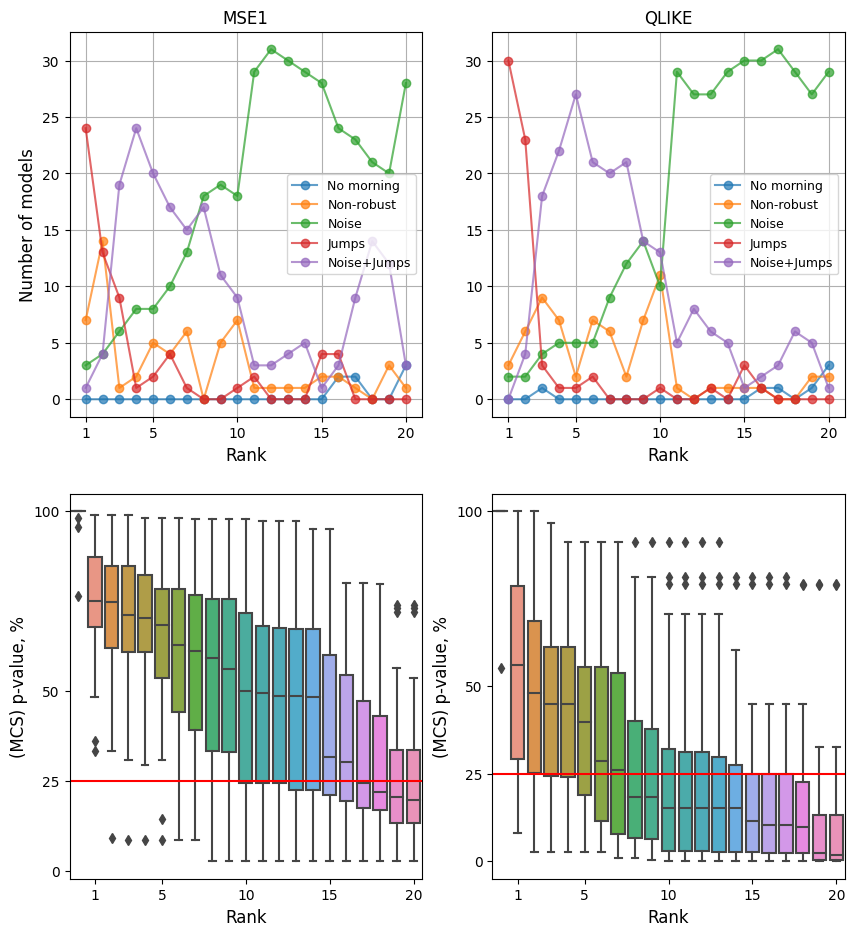

In [780]:
dist_of_morn(rez, ranks = 20)

In [764]:
noMorn, morn = set([0, 15]), set([1, 16])
noise = set([i for i in range(2, 11)] + [i for i in range(17, 26)])
jump = set([11] + [26])
noiseJumpy = set([i for i in range(12, 15)] + [i for i in range(27, 30)])

In [603]:
#rezMSE = []
rez = []
loz = []

for n in range(0, rvMain.shape[0]):
    print(tickers[n])
    loss = mcs_data_choice(n, split = 0.75)
    loss_fnc = list(loss.keys())[1:]

    mcsR = {fnc:MCS(loss[fnc], reps = 5000, method = 'max', size=0.1) for fnc in loss_fnc}
    
    for fnc in loss_fnc:
        mcsR[fnc].compute()

    
    rez.append({fnc:mcsR[fnc].pvalues for fnc in loss_fnc})
    loz.append(loss)

AAPL
AIG
AMGN
AXP
BA
BAC
C
CAT
CRM
CSCO
CVX
DIS
GS
HD
HON
HPQ
IBM
INTC
JNJ
JPM
KO
MCD
MDLZ
MMM
MO
MRK
MSFT
NKE
PFE
T
UNH
VZ
WBA
WMT
XOM


## Portfolio profitability

In [597]:
n = 3
h = 1

morning, main, evening, day = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
#morning, main, evening, day = np.log(1+rvMorning[n, :]), np.log(1+rvMain[n, :]), np.log(1+rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
                          np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))
#cP, cM, cE, jP, jM, jE = (np.log(1+cMorning[n, :]), np.log(1+cMain[n, :]), np.log(1+cEvening[n, :]),
#                          np.log(1+jMorning[n, :]), np.log(1+jMain[n, :]), np.log(1+jEvening[n, :]))
vP, vM, vE = np.sqrt(vMorning[n, :]), np.sqrt(vMain[n, :]), np.sqrt(vEvening[n, :])
dvP, dvM, dvE = np.sqrt(dvMorning[n, :]), np.sqrt(dvMain[n, :]), np.sqrt(dvEvening[n, :])
trainTestSplit = 0.75

xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
        #L(day, 1, harLength = 1), L(day, 5, harLength = 5), L(day, 22, harLength = 22),
        L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
        #L(morning, 1, harLength = 1), 
        #L(evening, 1, harLength = 1), 
        #L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
        #L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
        #L(vM, 1, harLength = 1),
        #L(cE, 1, harLength = 1),
        #L(jE, 1, harLength = 1),
        #L(cP, 0, harLength = 1),
        #L(jP, 0, harLength = 1),
        y = main, trainTestSplit = trainTestSplit)

l1 = OLS().predictRecursive(x, y, trainTestSplit).lossRecursive
a = OLS().predictRecursive(x, y, trainTestSplit).QLIKERecursive

xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
        #L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
        #L(morning, 0, harLength = 1), 
        #L(evening, 1, harLength = 1), 
        L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
        L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
        #L(vM, 1, harLength = 1),
        L(cP, 0, harLength = 1),
        L(jP, 0, harLength = 1),
        #L(vE, 1, harLength = 1),
        #L(dvP, 0, harLength = 1),
        #L(vE, 1, harLength = 1), 
        #L(dvE, 1, harLength = 1), 
        #L(cE, 1, harLength = 1),
        #L(jE, 1, harLength = 1),
        y = main , trainTestSplit = trainTestSplit)

l2 = OLS().predictRecursive(x, y, trainTestSplit).lossRecursive
b = OLS().predictRecursive(x, y, trainTestSplit).QLIKERecursive


In [33]:
trainTestSplit = 0.75

pred_l = [[] for i in range(18)]

for n in range(rvMain.shape[0]):
    # MAIN TARGET
    ## No noise
    morning, main, evening, day = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
    cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
                              np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[0].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[1].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[2].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[3].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)
    
    pred_l[4].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    ## Noise
    kP = np.sqrt(kMorning[n][0][0])
    ckP, jkP = np.sqrt(mkMorning[n][0]), np.sqrt(j2Morning[n][0])
                              
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(ckP, 0, harLength = 1),
            L(jkP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[5].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(ckP, 0, harLength = 1),
            L(jkP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[6].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(kP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[7].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(kP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    pred_l[8].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    # ALL TARGET, MORNING OF A CURRENT DAY USED
    ## No noise
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            y = np.sqrt(main**2 + evening**2), trainTestSplit = trainTestSplit)

    pred_l[9].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            y = np.sqrt(main**2 + evening**2), trainTestSplit = trainTestSplit)

    pred_l[10].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 0, harLength = 1),
            y = np.sqrt(main**2 + evening**2), trainTestSplit = trainTestSplit)

    pred_l[11].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            y = np.sqrt(main**2 + evening**2), trainTestSplit = trainTestSplit)

    pred_l[12].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            y = np.sqrt(main**2 + evening**2), trainTestSplit = trainTestSplit)
    
    pred_l[13].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
        
    ## Noise
    
    kE = np.sqrt(kEvening[n][0][1])
                              
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(ckP, 0, harLength = 1),
            L(jkP, 0, harLength = 1),
            y = np.sqrt(main**2 + kE**2), trainTestSplit = trainTestSplit)

    pred_l[14].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(ckP, 0, harLength = 1),
            L(jkP, 0, harLength = 1),
            y = np.sqrt(main**2 + kE**2), trainTestSplit = trainTestSplit)

    pred_l[15].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(kP, 0, harLength = 1),
            y = np.sqrt(main**2 + kE**2), trainTestSplit = trainTestSplit)

    pred_l[16].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(kP, 0, harLength = 1),
            y = np.sqrt(main**2 + kE**2), trainTestSplit = trainTestSplit)

    pred_l[17].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
        
pred = np.array(pred_l)

In [71]:
len(mkMorning[0][0])

3965

In [72]:
pred5 = []
trainTestSplit = 0.75
for n in range(rvMain.shape[0]):
    morning, main, evening, day = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
    #morning, main, evening, day = np.sqrt(kMorning[n][0][0]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
    
    #cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
    #                          np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))   
    cP, cM, cE, jP, jM, jE = (np.sqrt(mkMorning[n][0]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
                              np.sqrt(j2Morning[n][0]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            #L(morning, 0, harLength = 1),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            #L(cE, 1, harLength = 1),
            #L(jE, 1, harLength = 1),
            y = np.sqrt(rvMain[n, :] + rvEvening[n, :]), trainTestSplit = trainTestSplit)

    pred5.append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
                 
pred5 = np.array(pred5)

In [21]:
trainTestSplit = 0.6

predExt = [[[], [], []] for i in range(2)]

for n in range(rvMain.shape[0]):
    morning, main, evening, day = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
    cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
                              np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))
# 1. jump-main-morning
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 1, harLength = 1),
            L(jP, 1, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    predExt[0][2].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 1, harLength = 1),
            L(jP, 1, harLength = 1),
            L(cE, 1, harLength = 1),
            L(jE, 1, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    predExt[0][0].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    predExt[0][1].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
# 2. main-morning
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 1, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    predExt[1][2].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 1, harLength = 1),
            L(evening, 1, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    predExt[1][0].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 0, harLength = 1),
            y = main, trainTestSplit = trainTestSplit)

    predExt[1][1].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
        
#pred1, pred2, pred3, pred4, pred5, pred6 = np.array(pred1), np.array(pred2), np.array(pred3), np.array(pred4), np.array(pred5), np.array(pred6)
predExt = np.array(predExt)

In [22]:
trainTestSplit = 0.6

predW = [[] for i in range(5)]

for n in range(rvMain.shape[0]):
    morning, main, evening, day = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :]), np.sqrt(rvMorning[n, :]+rvMain[n, :]+rvEvening[n, :])
    cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
                              np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 0, harLength = 1),
            L(jP, 0, harLength = 1),
            y = L(main, 5, harLength = 5).to_numpy()**(1/2), trainTestSplit = trainTestSplit)

    predW[0].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)

    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            y = L(main, 5, harLength = 5).to_numpy()**(1/2), trainTestSplit = trainTestSplit)

    predW[1].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            L(morning, 0, harLength = 1),
            y = L(main, 5, harLength = 5).to_numpy()**(1/2), trainTestSplit = trainTestSplit)

    predW[2].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(main, 1, harLength = 1), L(main, 5, harLength = 5), L(main, 22, harLength = 22),
            y = L(main, 5, harLength = 5).to_numpy()**(1/2), trainTestSplit = trainTestSplit)

    predW[3].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
    
    xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
            L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
            L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
            L(cP, 1, harLength = 1),
            L(jP, 1, harLength = 1),
            L(cE, 1, harLength = 1),
            L(jE, 1, harLength = 1),
            y = L(day, 5, harLength = 5).to_numpy()**(1/2), trainTestSplit = trainTestSplit)
    
    predW[4].append(OLS().predictRecursive(x, y, trainTestSplit).predRecursive)
        
#pred1, pred2, pred3, pred4, pred5, pred6 = np.array(pred1), np.array(pred2), np.array(pred3), np.array(pred4), np.array(pred5), np.array(pred6)
predW = np.array(predW)


In [66]:
def portfolioPayoff(openPrices, pred, q1 = 0.85, q2 = 1, h = 1):
    portf = np.setdiff1d(np.where(pred[:, 0] > np.quantile(pred[:, 0], q1))[0], np.where(pred[:, 0] > np.quantile(pred[:, 0], q2))[0])
    share = 1/len(portf) * 1/openPrices[:, 0]
   
    payoff = []

    for t in range(h, pred.shape[1], h):
        p = 0
        
        nextPortf = np.setdiff1d(np.where(pred[:, t] > np.quantile(pred[:, t], q1))[0], np.where(pred[:, t] > np.quantile(pred[:, t], q2))[0])
        if len(nextPortf) == 0:
            nextShare = np.zeros(shape = openPrices.shape[0])
        else:
            nextShare = 1/len(nextPortf) * 1/openPrices[:, t]
        
        #p[np.setdiff1d(portf, nextPortf)] += openPrices[np.setdiff1d(portf, nextPortf), t]
        #p[np.setdiff1d(nextPortf, portf)] -= openPrices[np.setdiff1d(nextPortf, portf), t]
        
        p += openPrices[np.setdiff1d(portf, nextPortf), t] @ share[np.setdiff1d(portf, nextPortf)] # sell old ones
        p -= openPrices[np.intersect1d(portf, nextPortf), t] @ (nextShare[np.intersect1d(portf, nextPortf)] - share[np.intersect1d(portf, nextPortf)])
        p -= openPrices[np.setdiff1d(nextPortf, portf), t] @ nextShare[np.setdiff1d(nextPortf, portf)] 
        
        portf, share = nextPortf, nextShare
        portf = nextPortf
        payoff.append(p)
        #if p <= -1:
        #print(portf, p)
        #print(openPrices[portf, t] @ share[portf], nextPortf)
        
    return np.array(payoff)

In [ ]:
sp = pd.read_csv('sp500.csv')
p = sp['GSPC.Close'].to_numpy()

sr = np.log(p[1:]/p[:-1])

In [257]:
T = pred.shape[2]
kP = np.array([kMorning[n][0][0] for n in range(rvMain.shape[0])])

#r = np.array([portfolioPayoff(openPricesM[:, (rvMain.shape[1] - T):], predW[i, :, :], h = 5) for i in range(5)])
rd = [sr[(rvMain.shape[1] - T-1):]] + [portfolioPayoff(openPricesM[:, (rvMain.shape[1] - T):], pred[i, :, :], h = 1) for i in range(9)]
rd.extend([portfolioPayoff(openPricesM[:, (rvMain.shape[1] - T):], rvMorning[:, (rvMain.shape[1] - T):] + pred[i, :, :]**2, h = 1) for i in range(9, 14)])
rd.extend([portfolioPayoff(openPricesM[:, (rvMain.shape[1] - T):], kP[:, (rvMain.shape[1] - T):] + pred[i, :, :]**2, h = 1) for i in range(14, 18)])
rd = np.array(rd)

In [268]:
md = []

for start in range(0, 600, 20):
    shift = 600 - start

    md.append(np.mean(rd[:, start:-shift], axis = 1))

md = np.array(md).T

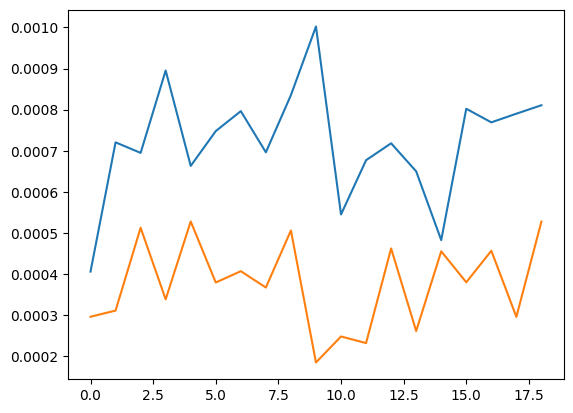

In [271]:
plt.plot(md[0, :])
plt.plot(md[-1, :])

In [263]:
model = 9
(md[model] - md[0])/neweyWest((rd[model, :] - rd[0, :]).reshape(rd.shape[1], 1))[0, 0]**(1/2)*np.sqrt(T-shift-start)

0.9719085176045476

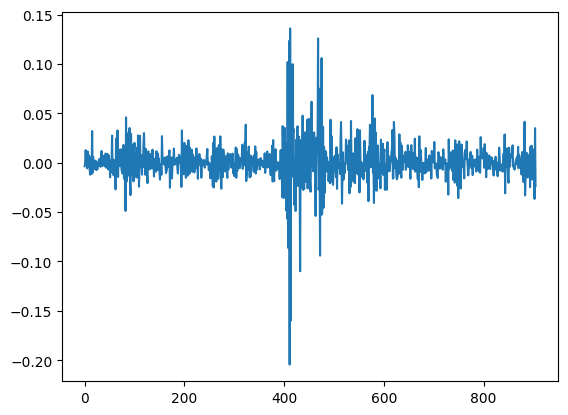

In [144]:
plt.plot((rd[model, :]  - sr5).reshape(rd.shape[1], 1))

In [145]:
def indPayoff(openPrices, pred, vol, q = 0.85, h = 1):
    portf = np.where(pred[:, 0] > np.quantile(vol[:, 0], q))[0]
    
    returns = []

    for t in range(h, pred.shape[1]-h, h):
        r = np.zeros(shape = pred.shape[0])
      
        if len(portf) > 0:
            r[portf] = (openPrices[portf, t] - openPrices[portf, t-1])/openPrices[portf, t-1]
        
        portf = np.where(pred[:, t] > np.quantile(vol[:, t], q))[0]
        returns.append(r)
        
        
        
    #p = np.zeros(shape = pred.shape[0])
    #p[portf] += openPrices[portf, t+h]
    #payoff.append(p)
        
    return np.array(returns)

In [32]:
def indExtPayoff(openPrices, pred, vol, q = 0.8, h = 1):
    portf = np.where(pred[0, :, 0] > np.quantile(vol[:, 0], q))[0]
    
    returns = []

    for t in range(0, pred.shape[2]-h, h):
        r = np.zeros(shape = pred.shape[1])
        
        r[portf] += np.log(openPrices[1, portf, t]/openPrices[0, portf, t])
        portf = np.where(pred[1, :, t] > np.quantile(vol[:, t], q))[0]
        
        r[portf] += np.log(openPrices[2, portf, t]/openPrices[1, portf, t])
        portf = np.where(pred[2, :, t] > np.quantile(vol[:, t+1], q))[0]
        
        r[portf] += np.log(openPrices[0, portf, t+1]/openPrices[2, portf, t])
        portf = np.where(pred[0, :, t+1] > np.quantile(vol[:, t+1], q))[0]
            
        returns.append(r)
        
    return np.array(returns)

In [34]:
T = pred.shape[2]
openP = np.array([openPricesP, openPricesM, openPricesE])

rExt = np.array([indExtPayoff(openP[:,:, (rvMain.shape[1] - T):], predExt[i, :, :, :]**2, rvMain[:, (rvMain.shape[1] - T-1):]) for i in range(2)])

In [217]:
T = pred.shape[2]
rvDay = rvMorning + rvMain + rvEvening
kP, kE = np.array([kMorning[n][0][0] for n in range(rvMain.shape[0])]), np.array([kEvening[n][1][0] for n in range(rvMain.shape[0])])
kDay = kP + rvMain + kE

shift = 1
start = 600

r = [indPayoff(openPricesM[:, (rvMain.shape[1] - T+start):-shift], pred[i, :, start:-shift]**2, rvMain[:, (rvMain.shape[1] - T-1+start):-shift - 1]) for i in range(9)]
r.extend([indPayoff(openPricesM[:, (rvMain.shape[1] - T+start):-shift], rvMorning[:, (rvMain.shape[1] - T+start):-shift] + pred[i, :, start:-shift]**2, rvDay[:, (rvMain.shape[1] - T-1+start):-shift - 1]) for i in range(9, 14)])
r.extend([indPayoff(openPricesM[:, (rvMain.shape[1] - T+start):-shift], kP[:, (rvMain.shape[1] - T+start):-shift] + pred[i, :, start:-shift]**2, kDay[:, (rvMain.shape[1] - T-1+start):-shift - 1]) for i in range(14, 18)])

r = np.array(r)

In [218]:
m = np.mean(r, axis = 1)
#print(np.r_[m, mExt].shape)
print(np.unique(np.argmax(m, axis = 0), return_counts = True))
#print(np.array(tickers)[(np.argmax(np.r_[m, mExt], axis = 0) == 0) | (np.argmax(np.r_[m, mExt], axis = 0) == 7)])

(array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 13, 14, 15, 17], dtype=int64), array([2, 1, 2, 5, 2, 2, 4, 2, 2, 1, 3, 7, 2], dtype=int64))


<BarContainer object of 13 artists>

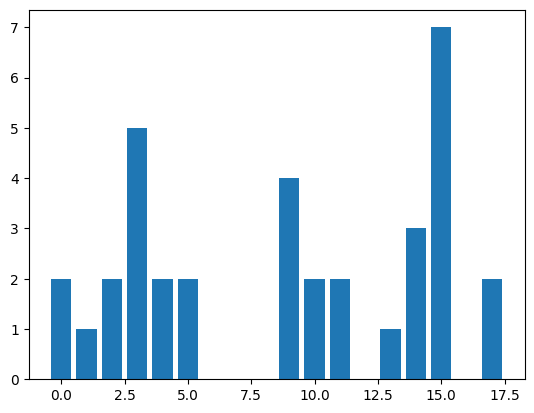

In [219]:
plt.bar(np.unique(np.argmax(m, axis = 0), return_counts = True)[0], np.unique(np.argmax(m, axis = 0), return_counts = True)[1])

In [159]:
def compare(m, r, d1, d2):
    return ((m[d1, np.argmax(m, axis = 0) == d1] - m[d2, np.argmax(m, axis = 0) == d1]) / 
    np.diag(neweyWest((r[d1, :, np.argmax(m, axis = 0) == d1] - r[d2, :, np.argmax(m, axis = 0) == d1]).T))**(1/2) * np.sqrt(T-shift)
, np.argmax(m, axis = 0) == d1)

In [163]:
compare(m, r, 13, 8)

(array([1.97289364, 1.85984699, 1.91073911, 1.19154435, 1.47389802,
        1.38917053, 2.19254261, 1.87791495]),
 array([False, False, False, False, False,  True,  True, False, False,
         True, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False,  True,  True,
        False,  True, False, False, False, False, False, False]))

## Smth on skewness

In [42]:
#morning, main, evening = np.sqrt(rvMorning[n, :]), np.sqrt(rvMain[n, :]), np.sqrt(rvEvening[n, :])
#cP, cM, cE, jP, jM, jE = (np.sqrt(cMorning[n, :]), np.sqrt(cMain[n, :]), np.sqrt(cEvening[n, :]),
#                          np.sqrt(jMorning[n, :]), np.sqrt(jMain[n, :]), np.sqrt(jEvening[n, :]))

n = 0
trainTestSplit = 0.9
skP, skM, skE = rskMorning[n, :], rskMain[n, :], rskEvening[n, :]


xTrain, yTrain, xTest, yTest, x, y = preprocessLags(
        L(skM, 1, harLength = 1), L(skM, 5, harLength = 5), L(skM, 22, harLength = 22),
        L(skP, 1, harLength = 1),
        #L(cM, 1, harLength = 1), L(cM, 5, harLength = 5), L(cM, 22, harLength = 22),
        #L(jM, 1, harLength = 1), L(jM, 5, harLength = 5), L(jM, 22, harLength = 22),
        #L(cP, 4, harLength = 1),
        #L(jP, 4, harLength = 1),
        y = skM, trainTestSplit = trainTestSplit)

b = OLS().predictRecursive(x, y, trainTestSplit).predRecursive

In [36]:
b

1.178763801741556

In [38]:
b

1.1779070127010418

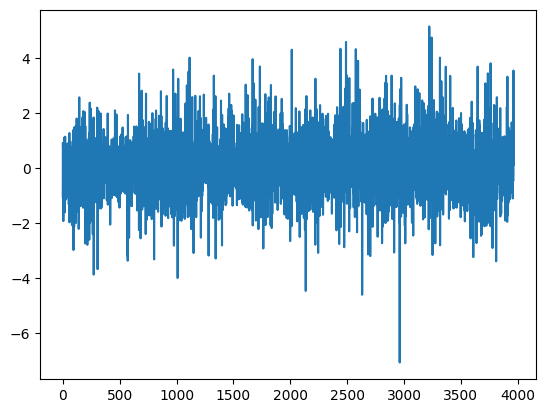

In [43]:
plt.plot(skM)